In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm_notebook
import  matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
import numpy as np
import pandas as pd
from sklearn import preprocessing

np.random.seed(1234)

load data and make data sets and dataloaders

In [0]:
data = pd.read_csv('/content/House Sales.csv')
data = data.drop(['id', 'date'], axis= 1)

# normalize
x = data.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(data)
df = pd.DataFrame(x_scaled , columns=data.columns)

# shuffle df
df = df.sample(frac=1).reset_index(drop=True)

# split train and test
train = df[0:4000]
test  = df[4000:5000]

train_t = train.price
train_f = train.drop(['price'], axis=1)

test_t = test.price
test_f = test.drop(['price'], axis=1)

make dataset

In [0]:
class DF_DS(Dataset):
    def __init__(self, dff,dft):
        
        assert(len(dff) == len(dft))
        super().__init__()
        self.len = len(dff)
        self.dff = dff
        self.dft = dft

    def __getitem__(self, index): 
        
        feature = torch.tensor(self.dff.iloc[index])
        target  = torch.tensor(self.dft.iloc[index]).view(1,)
        
        return  feature, target
       
    def __len__(self):
        return self.len

In [0]:
train_ds = DF_DS(train_f, train_t)
test_ds  = DF_DS(test_f, test_t)

In [0]:
f , t = next(iter(train_ds))
f.shape , t.shape

(torch.Size([18]), torch.Size([1]))

make data loader

In [0]:
batch_size = 10
train_dl = DataLoader(train_ds , batch_size=batch_size , shuffle= True , num_workers = 1)
test_dl = DataLoader(test_ds , batch_size=batch_size , shuffle= False , num_workers = 1)

In [0]:
fs , ts = next(iter(train_dl))
fs.shape , ts.shape

(torch.Size([10, 18]), torch.Size([10, 1]))

make the network

In [0]:
class MLP1(nn.Module):
    def __init__(self, input_dim, hidden = 10, output_dim = 1):
        super().__init__()
        self.n = input_dim
        self.hidden = hidden
        self.o = output_dim

        self.fc1  = nn.Linear(self.n, self.hidden)
        self.act1 = nn.Tanh()
        self.fc2  = nn.Linear(self.hidden, self.o)
        self.act2 = nn.Tanh()

    def forward(self, x):
        out = self.fc1(x)
        out = self.act1(out)
        out = self.fc2(out)
        out = self.act2(out)

        return out

In [0]:
net = MLP1(input_dim=train_f.shape[1])

choose loss function and optimizer

In [0]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(),lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)

training part

In [0]:
def train_step(model, train_dl, criterion, optimizer):
    total_loss = 0.0
    
    for i, (train_inputs, train_labels) in tqdm_notebook(enumerate(train_dl), 
                                                         desc='Training', 
                                                         total=len(train_dl)):
        optimizer.zero_grad()
        output = model(train_inputs)
        loss = criterion(output, train_labels)
        loss.backward()     
        optimizer.step()
        total_loss += loss.item()

    return total_loss/len(train_dl)


def validate_step(model, valid_dl, criterion):
    total_loss = 0.0
    with torch.no_grad():
        for i, (test_inputs, test_labels) in tqdm_notebook(enumerate(valid_dl), 
                                                        desc='Validation', 
                                                        total=len(valid_dl)):
            output = model(test_inputs)
            loss = criterion(output, test_labels)
            total_loss += loss.item()

    return total_loss/len(test_dl)


def train(model, train_dl, valid_dl, criterion, optimizer, scheduler, num_epochs, train_hist, test_hist):
    
    best_wts = None
    best_loss = float('inf')

    for epoch in range(num_epochs):

        ## perform one epoch of training and validation
        trn_loss = train_step(model, train_dl, criterion, optimizer)
        val_loss = validate_step(model, valid_dl, criterion)
        scheduler.step()

        train_hist += [trn_loss]
        test_hist  += [val_loss]

#         # save weights
#         if val_loss < best_loss:
#             best_loss = val_loss
#             best_wts = model.state_dict().copy()
            
# #             torch.save(best_wts, 'models/lstm-{}-{}-{}-{}-{}-{}-{:.5f}.pth'.format(
# #                 epoch, max_len, min_count, model.embed_size, model.hidden_size, model.num_layers, best_acc))

        print(f'[Epoch:{epoch+1}/{num_epochs}] Training Loss: %.4f Testing Loss: %.4f'
              % (trn_loss* 10000, val_loss* 10000))

    # model.load_state_dict(best_wts)
    return train_hist, test_hist

In [0]:
train_hist, test_hist = [], []

In [0]:
train_hist, test_hist = train(net, train_dl, test_dl, criterion, optimizer, scheduler, 100, train_hist, test_hist)

Text(0.5, 1.0, 'trianing loss')

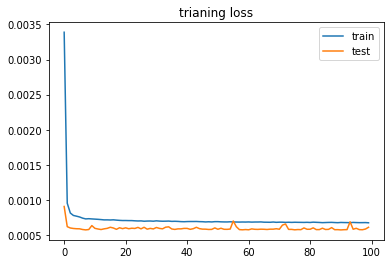

In [0]:

plt.plot([i for i in train_hist] , label='train')
plt.plot([i for i in test_hist ] , label ='test')
plt.legend()
plt.title('trianing loss')

visualize result

In [0]:
def visualize_result(model, dl, min_max_scaler, dl_name):
    data = []
    with torch.no_grad(): # to increase speed
        for i, (fs, ts) in tqdm_notebook(enumerate(dl), 
                                                        desc='Validation', 
                                                        total=len(dl)):
            batch = np.hstack((ts.numpy(), fs.numpy()))
            batch_pred = np.hstack((net(fs).detach().numpy() , fs.numpy()))
            data += [(min_max_scaler.inverse_transform(batch)[0,0],min_max_scaler.inverse_transform(batch_pred)[0,0])]


    data = sorted(data, key=(lambda x:x[0]))
    real = np.array([i[0] for i in data])
    pred = np.array([i[1] for i in data])
    mse = np.mean((real - pred)**2)**0.5

    plt.plot(pred, label='pred', c='gray')
    plt.plot(real, label='real' , c='red')
    plt.legend()
    plt.ylabel('price')
    plt.title('performance of medel on '+ dl_name + f'data: rmse loss = {mse}' )
    plt.show()


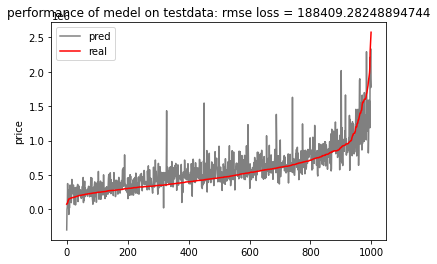

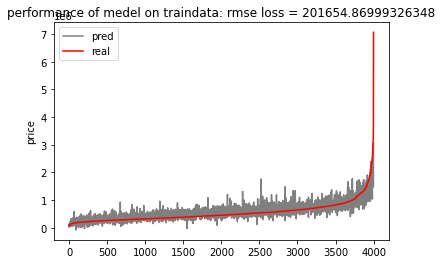

In [0]:
batch_size = 1
train_dl = DataLoader(train_ds , batch_size=batch_size , shuffle= True , num_workers = 1)
test_dl = DataLoader(test_ds , batch_size=batch_size , shuffle= False , num_workers = 1)
visualize_result(net, test_dl, min_max_scaler, 'test')
visualize_result(net, train_dl, min_max_scaler, 'train')

In [0]:
class MLP2(nn.Module):
    def __init__(self, input_dim, hidden1 = 30, hidden2 = 10, output_dim = 1):
        super().__init__()
        self.n = input_dim
        self.hidden1 = hidden1
        self.hidden2 = hidden2
        self.o = output_dim

        self.fc1  = nn.Linear(self.n, self.hidden1)
        self.act1 = nn.Tanh()
        self.fc2  = nn.Linear(self.hidden1, self.hidden2)
        self.act2 = nn.Tanh()
        self.fc3  = nn.Linear(self.hidden2, self.o)
        self.act3 = nn.Tanh()

    def forward(self, x):
        out = self.fc1(x)
        out = self.act1(out)
        out = self.fc2(out)
        out = self.act2(out)
        out = self.fc3(out)
        out = self.act3(out)

        return out

In [0]:
batch_size = 10
train_dl = DataLoader(train_ds , batch_size=batch_size , shuffle= True , num_workers = 1)
test_dl = DataLoader(test_ds , batch_size=batch_size , shuffle= False , num_workers = 1)

In [0]:
net = MLP2(input_dim=train_f.shape[1])

In [0]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(),lr=0.5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

In [0]:
train_hist, test_hist = [], []

In [0]:
train_hist, test_hist = train(net, train_dl, test_dl, criterion, optimizer, scheduler, 50, train_hist, test_hist)

Text(0.5, 1.0, 'trianing loss')

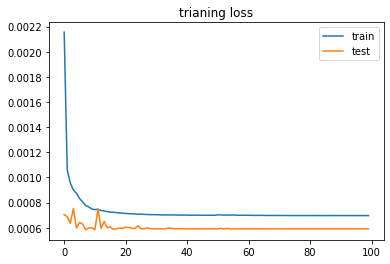

In [0]:

plt.plot([i for i in train_hist] , label='train')
plt.plot([i for i in test_hist ] , label ='test')
plt.legend()
plt.title('trianing loss')

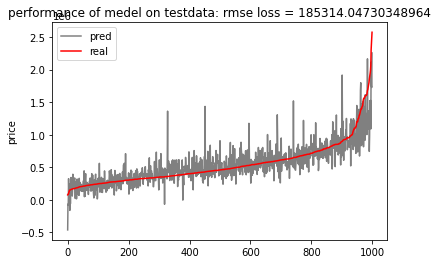

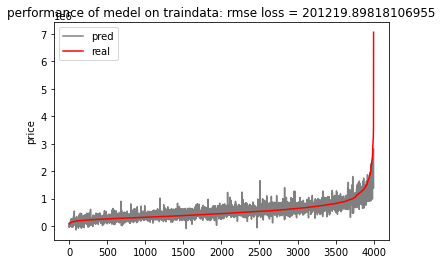

In [0]:
batch_size = 1
train_dl = DataLoader(train_ds , batch_size=batch_size , shuffle= True , num_workers = 1)
test_dl = DataLoader(test_ds , batch_size=batch_size , shuffle= False , num_workers = 1)
visualize_result(net, test_dl, min_max_scaler, 'test')
visualize_result(net, train_dl, min_max_scaler, 'train')